### 1. Data source: SoC EIS LFP dataset

For this notebook I use the public dataset:

> Mustafa, Hamza; Bourelly, Carmine; Vitelli, Michele; Milano, Fillippo; Molinara, Mario; Ferrigno, Luigi (2024),  
> **“SoC Estimation on Li-ion Batteries: A New EIS-based Dataset for data-driven applications”**,  
> Mendeley Data, V2, doi: 10.17632/cb887gkmxw.2.  
> Available at: https://data.mendeley.com/datasets/cb887gkmxw/2  
> License: **CC BY 4.0**

Dataset highlights:

- 11 cylindrical **LFP** cells (B01–B11).
- EIS at 19 SoC levels: 100%, 95%, 90%, 85%, 80%, 75%, 70%, 65%, 60%, 55%, 50%, 45%, 35%, 30%, 25%, 20%, 15%, 10%, 5%.
- Two discharge cycles per cell, same frequency grid from 0.01 Hz to 1000 Hz (28 frequencies).

Folder structure (after downloading the dataset into `../data/soc_eis_lfp/`):

- One folder per cell: `B01`, `B02`, ..., `B11`.
- Inside each `Bxx` folder:
  - `EIS Measurement/` — subfolders with the actual EIS CSV files.
  - `Capacity Measurement/` — capacity test CSV (not used in this first notebook).


### 2. Load data & quick sanity checks.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_ROOT = Path("../data/soc_eis_lfp")

COLUMN_MAP = {
    "Frequency(Hz)": "frequency_hz",
    "R(ohm)": "z_real_ohm",
    "X(ohm)": "z_imag_ohm",
    "T(deg C)": "temperature_c",
}

def load_soc_eis(data_root: Path) -> pd.DataFrame:
    records = []

    for batt in range(1, 12):  # B01 .. B11
        battery_id = f"B{batt:02d}"

        for test_name, cycle in [("Test_1", 1), ("Test_2", 2)]:
            hioki_dir = data_root / battery_id / "EIS measurements" / test_name / "Hioki"

            for csv_path in sorted(hioki_dir.glob("*.csv")):
                # Hk_IFR14500_SoC_100_03-07-2023_11-46.csv -> SoC = 100
                fname_parts = csv_path.stem.split("_")
                soc = int(fname_parts[3])

                df_raw = pd.read_csv(csv_path)
                df = df_raw[list(COLUMN_MAP.keys())].rename(columns=COLUMN_MAP)

                df["battery_id"] = battery_id
                df["cycle"] = cycle
                df["soc"] = soc

                records.append(df)

    full_df = pd.concat(records, ignore_index=True)
    return full_df

eis_df = load_soc_eis(DATA_ROOT)

# Quick sanity checks
print("Shape:", eis_df.shape)
print("Batteries:", eis_df["battery_id"].unique())
print("Cycles:", sorted(eis_df["cycle"].unique()))
print("Unique SOCs:", sorted(eis_df["soc"].unique()))
print("Freq min/max:", eis_df["frequency_hz"].min(), "→", eis_df["frequency_hz"].max())
print("Temp min/max:", eis_df["temperature_c"].min(), "→", eis_df["temperature_c"].max())

eis_df.head()


Shape: (12320, 7)
Batteries: ['B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B10' 'B11']
Cycles: [np.int64(1), np.int64(2)]
Unique SOCs: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100)]
Freq min/max: 0.01 → 1000.0
Temp min/max: 20 → 20


,frequency_hz,z_real_ohm,z_imag_ohm,temperature_c,battery_id,cycle,soc
0,0.01,0.227844,-0.313990,20,B01,1,100
1,0.02,0.182858,-0.197273,20,B01,1,100
2,0.03,0.163270,-0.160068,20,B01,1,100
3,0.05,0.138709,-0.113159,20,B01,1,100
4,0.08,0.121685,-0.082724,20,B01,1,100


In [2]:
# Basic overview
eis_df.describe(include="all").round(3)


,frequency_hz,z_real_ohm,z_imag_ohm,temperature_c,battery_id,cycle,soc
count,12320.000,12320.000,12320.000,12320.0,12320,12320.0,12320.000
unique,NaN,NaN,NaN,NaN,11,NaN,NaN
top,NaN,NaN,NaN,NaN,B01,NaN,NaN
freq,NaN,NaN,NaN,NaN,1120,NaN,NaN
mean,117.360,0.078,-0.015,20.0,NaN,1.5,52.500
std,246.764,0.025,0.031,0.0,NaN,0.5,28.833
min,0.010,0.042,-1.329,20.0,NaN,1.0,5.000
25%,0.275,0.061,-0.015,20.0,NaN,1.0,28.750
50%,6.500,0.072,-0.007,20.0,NaN,1.5,52.500
75%,85.750,0.089,-0.006,20.0,NaN,2.0,76.250


In [3]:
# 1) Missing values
eis_df.isna().sum()


frequency_hz     0
z_real_ohm       0
z_imag_ohm       0
temperature_c    0
battery_id       0
cycle            0
soc              0
dtype: int64

In [4]:
# 2) Duplicate rows
eis_df.duplicated().sum()


np.int64(0)

In [5]:
# 3) Per-spectrum point count
pts_per_spectrum = (
    eis_df
    .groupby(["battery_id", "cycle", "soc"])["frequency_hz"]
    .count()
)

print("Unique point counts per spectrum:", pts_per_spectrum.unique())
pts_per_spectrum.describe()


Unique point counts per spectrum: [28]


count    440.0
mean      28.0
std        0.0
min       28.0
25%       28.0
50%       28.0
75%       28.0
max       28.0
Name: frequency_hz, dtype: float64

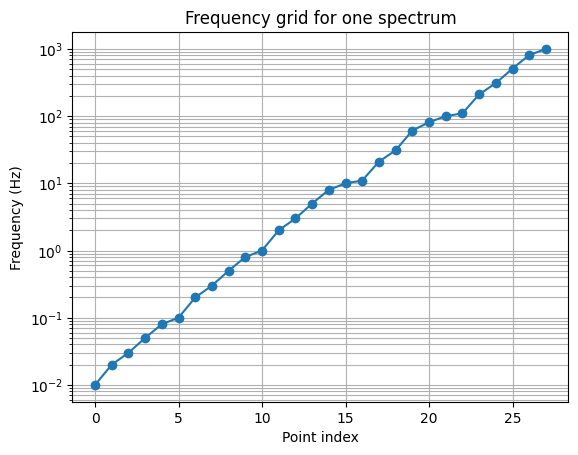

In [6]:
import matplotlib.pyplot as plt

spec = (
    eis_df
    .query("battery_id == 'B01' and cycle == 1 and soc == 50")
    .sort_values("frequency_hz")
)

spec = spec.reset_index(drop=True)

plt.figure()
spec["frequency_hz"].plot(marker="o")
plt.yscale("log")
plt.xlabel("Point index")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency grid for one spectrum")
plt.grid(True, which="both")
plt.show()


### 2. EIS visualisation vs SOC

#### 2.1 Add magnitude and phase


In [7]:
eis_df["z_mag_ohm"] = np.sqrt(eis_df["z_real_ohm"]**2 + eis_df["z_imag_ohm"]**2)
eis_df["z_phase_deg"] = np.degrees(np.arctan2(eis_df["z_imag_ohm"], eis_df["z_real_ohm"]))


#### 2.2 Nyquist plots at different SOCs (one battery, one cycle)


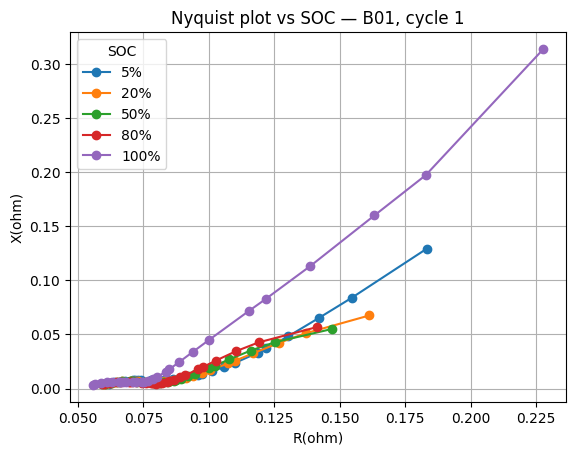

In [8]:
battery_id_to_plot = "B01"
cycle_to_plot = 1

sub = eis_df[
    (eis_df["battery_id"] == battery_id_to_plot)
    & (eis_df["cycle"] == cycle_to_plot)
].copy()

soc_levels_to_plot = [5, 20, 50, 80, 100]
soc_levels_available = sorted(sub["soc"].unique())
soc_levels_to_plot = [s for s in soc_levels_to_plot if s in soc_levels_available]

plt.figure()

for soc in soc_levels_to_plot:
    g = sub[sub["soc"] == soc].sort_values("frequency_hz")
    plt.plot(g["z_real_ohm"], -g["z_imag_ohm"], marker="o", label=f"{soc}%")

plt.xlabel("R(ohm)")
plt.ylabel("X(ohm)")
plt.title(f"Nyquist plot vs SOC — {battery_id_to_plot}, cycle {cycle_to_plot}")
plt.legend(title="SOC")
plt.grid(True)
plt.show()


#### 2.3 Bode plots (magnitude & phase vs frequency)


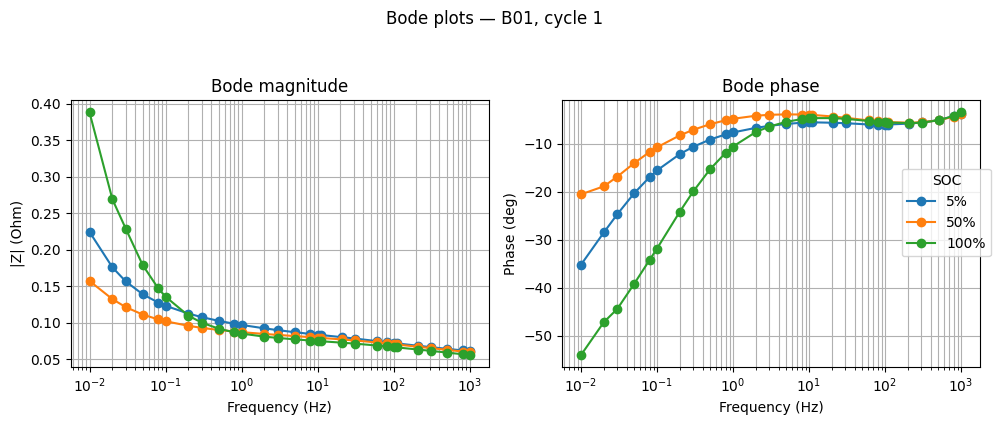

In [9]:
from matplotlib.ticker import ScalarFormatter

battery_id_to_plot = "B01"
cycle_to_plot = 1

sub = eis_df[
    (eis_df["battery_id"] == battery_id_to_plot)
    & (eis_df["cycle"] == cycle_to_plot)
].copy()

soc_levels_to_plot = [5, 50, 100]
soc_levels_available = sorted(sub["soc"].unique())
soc_levels_to_plot = [s for s in soc_levels_to_plot if s in soc_levels_available]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

ax_mag, ax_phase = axes

# --- Magnitude ---
for soc in soc_levels_to_plot:
    g = sub[sub["soc"] == soc].sort_values("frequency_hz")
    ax_mag.semilogx(g["frequency_hz"], g["z_mag_ohm"], marker="o", label=f"{soc}%")

ax_mag.set_xlabel("Frequency (Hz)")
ax_mag.set_ylabel("|Z| (Ohm)")
ax_mag.set_title("Bode magnitude")
ax_mag.grid(True, which="both")

sf = ScalarFormatter()
sf.set_scientific(False)
sf.set_useOffset(False)
ax_mag.yaxis.set_major_formatter(sf)

# --- Phase ---
for soc in soc_levels_to_plot:
    g = sub[sub["soc"] == soc].sort_values("frequency_hz")
    ax_phase.semilogx(g["frequency_hz"], g["z_phase_deg"], marker="o", label=f"{soc}%")

ax_phase.set_xlabel("Frequency (Hz)")
ax_phase.set_ylabel("Phase (deg)")
ax_phase.set_title("Bode phase")
ax_phase.grid(True, which="both")

# One shared legend
handles, labels = ax_mag.get_legend_handles_labels()
fig.legend(handles, labels, title="SOC", loc="center right", ncol=1)

fig.suptitle(f"Bode plots — {battery_id_to_plot}, cycle {cycle_to_plot}", y=1.05)
plt.tight_layout()
plt.show()


### 3. Feature engineering: simple impedance fingerprints

Goal: compress each full EIS spectrum into a small feature vector, one row per  
**(battery_id, cycle, SOC)**, that we can later feed to a simple ML model.

In this section I will:
- Create one feature row per (battery_id, cycle, soc).
- Use basic summary features (min/max/mean) of |Z| and phase.
- Sample |Z| and phase at a few fixed frequencies on a log-scale grid.


#### 3.1 Define target frequencies for features


In [10]:
# Frequencies (within the 0.01–1000 Hz range) where we sample |Z| and phase
target_freqs = [0.1, 1.0, 10.0, 100.0]
target_freqs


[0.1, 1.0, 10.0, 100.0]

#### 3.2 Build one feature vector per (battery_id, cycle, SOC)

For each full EIS spectrum I create a single feature row.  
I also interpolate |Z| and phase to a few fixed frequencies (0.1, 1, 10, 100 Hz),  
so every spectrum has the same “canonical” features even if the measured  
frequency grid does not hit those values exactly.


In [11]:
feature_rows = []

for (battery_id, cycle, soc), g in eis_df.groupby(["battery_id", "cycle", "soc"]):
    g = g.sort_values("frequency_hz")

    freq = g["frequency_hz"].to_numpy()
    z_real = g["z_real_ohm"].to_numpy()
    z_mag = g["z_mag_ohm"].to_numpy()
    phase = g["z_phase_deg"].to_numpy()

    row = {
        "battery_id": battery_id,
        "cycle": cycle,
        "soc": soc,
        "zreal_lowfreq": z_real[0],
        "zreal_highfreq": z_real[-1],
        "zmag_mean": z_mag.mean(),
        "zmag_max": z_mag.max(),
        "phase_min": phase.min(),
        "phase_max": phase.max(),
    }

    # Sample |Z| and phase at fixed frequencies (log-frequency interpolation)
    logf = np.log10(freq)

    for f in target_freqs:
        logf_target = np.log10(f)
        zmag_f = np.interp(logf_target, logf, z_mag)
        phase_f = np.interp(logf_target, logf, phase)

        freq_label = str(f).replace(".", "p")
        row[f"zmag_{freq_label}Hz"] = zmag_f
        row[f"phase_{freq_label}Hz"] = phase_f

    feature_rows.append(row)

feat_df = pd.DataFrame(feature_rows)
feat_df.head()


,battery_id,cycle,soc,zreal_lowfreq,zreal_highfreq,zmag_mean,zmag_max,phase_min,phase_max,zmag_0p1Hz,phase_0p1Hz,zmag_1p0Hz,phase_1p0Hz,zmag_10p0Hz,phase_10p0Hz,zmag_100p0Hz,phase_100p0Hz
0,B01,1,5,0.183274,0.060853,0.098445,0.224320,-35.212401,-3.758229,0.123168,-15.565790,0.096885,-7.652215,0.083543,-5.550934,0.072120,-6.004345
1,B01,1,10,0.169218,0.060370,0.092736,0.187253,-25.353367,-3.705353,0.114262,-13.170175,0.092355,-6.683861,0.081071,-4.803984,0.071425,-5.604848
2,B01,1,15,0.164845,0.060062,0.091440,0.178397,-22.476578,-3.691375,0.112135,-12.454716,0.091528,-6.344858,0.080818,-4.748885,0.071235,-5.604166
3,B01,1,20,0.161374,0.059784,0.090420,0.174977,-22.741806,-3.723559,0.109993,-12.250594,0.090529,-6.039475,0.080474,-4.593013,0.070998,-5.609070
4,B01,1,25,0.158583,0.059604,0.089624,0.171185,-22.121807,-3.748970,0.108445,-11.967235,0.089848,-5.802213,0.080257,-4.495244,0.070852,-5.625928


#### 3.3 Visualise key feature distributions

Before modelling, I check a few key feature distributions to see:

- that values look reasonable,
- and that there is some spread across samples (so the model has signal to learn from).


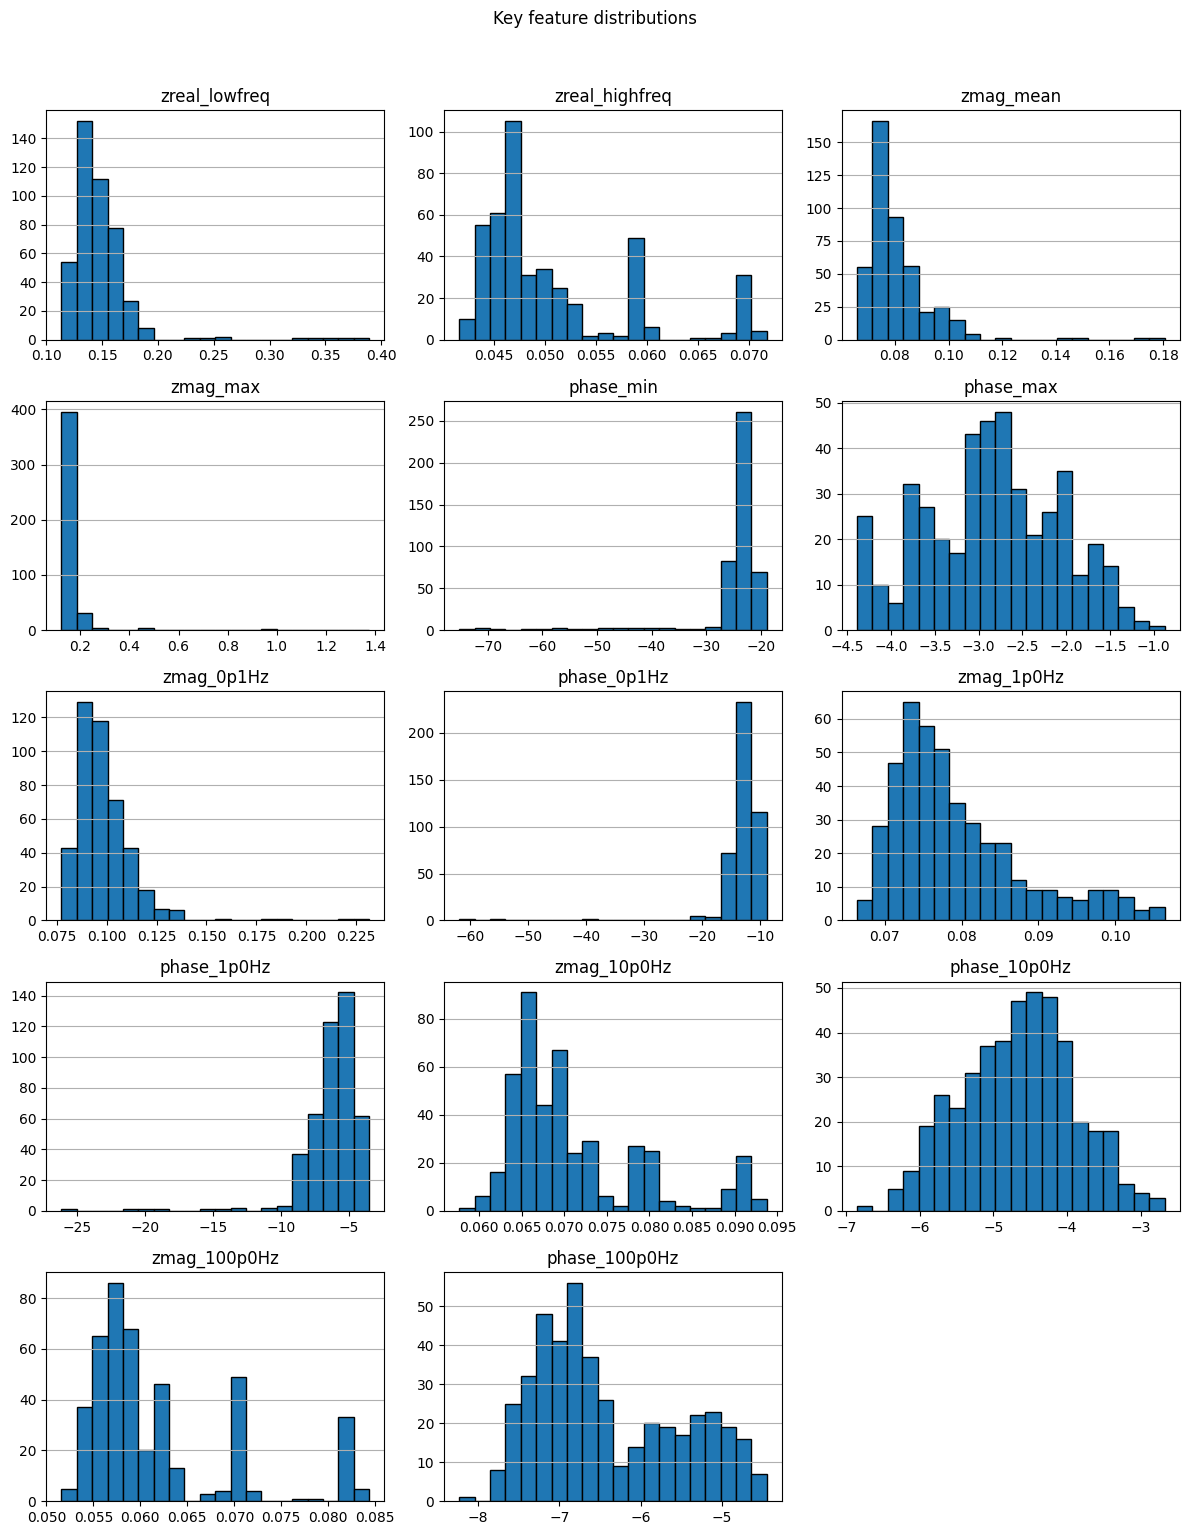

In [22]:
key_features = feat_df.columns.values[3:].tolist()

n = len(key_features)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for ax, feat in zip(axes, key_features):
    ax.hist(feat_df[feat], bins=20, edgecolor="black")
    ax.set_title(feat)
    ax.grid(True, axis="y")

# Hide any unused subplots
for ax in axes[len(key_features):]:
    ax.set_visible(False)

fig.suptitle("Key feature distributions", y=1.02)
plt.tight_layout()
plt.show()


#### 3.4 Correlation heatmap of engineered features

I use a simple correlation heatmap to see how the engineered features relate  
to each other (and to SOC), and to spot highly redundant features.

Here I use **Spearman rank correlation** between all numeric features  
and mark statistically significant correlations:

- `*`  : p < 0.05  
- `**` : p < 0.01  
- `***`: p < 0.001

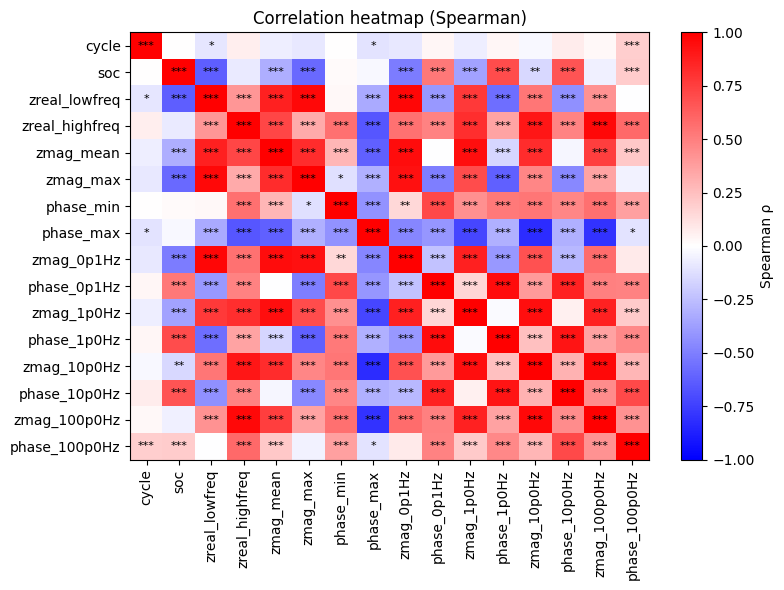

In [24]:
from scipy.stats import spearmanr

# Numeric features only (skip battery_id, cycle if they are non-numeric)
numeric_cols = feat_df.select_dtypes(include=[np.number]).columns.tolist()

# Spearman correlation and p-values
corr_matrix, p_matrix = spearmanr(feat_df[numeric_cols].values)
corr = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)
pvals = pd.DataFrame(p_matrix, index=numeric_cols, columns=numeric_cols)

fig, ax = plt.subplots(figsize=(8, 6))

# Blue–white–red colormap, symmetric scale
im = ax.imshow(corr.values, cmap="bwr", vmin=-1, vmax=1, aspect="auto")

ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Spearman ρ")

ax.set_title("Correlation heatmap (Spearman)")

# Add significance stars
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        p = pvals.iloc[i, j]
        if p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = ""
        if star:
            ax.text(j, i, star, ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()


#### 3.5 SOC vs significantly correlated features (aggregated by SOC)

Scatter plots were noisy, so here I aggregate by SOC and plot, for each  
significant feature (p < 0.05):

- median value vs SOC (line),
- 25–75% range vs SOC (shaded band).

This makes monotonic trends much easier to see.


Significant features (p < 0.05): ['phase_1p0Hz', 'phase_10p0Hz', 'zreal_lowfreq', 'zmag_max', 'phase_0p1Hz', 'zmag_0p1Hz', 'zmag_1p0Hz', 'zmag_mean', 'phase_100p0Hz', 'zmag_10p0Hz']


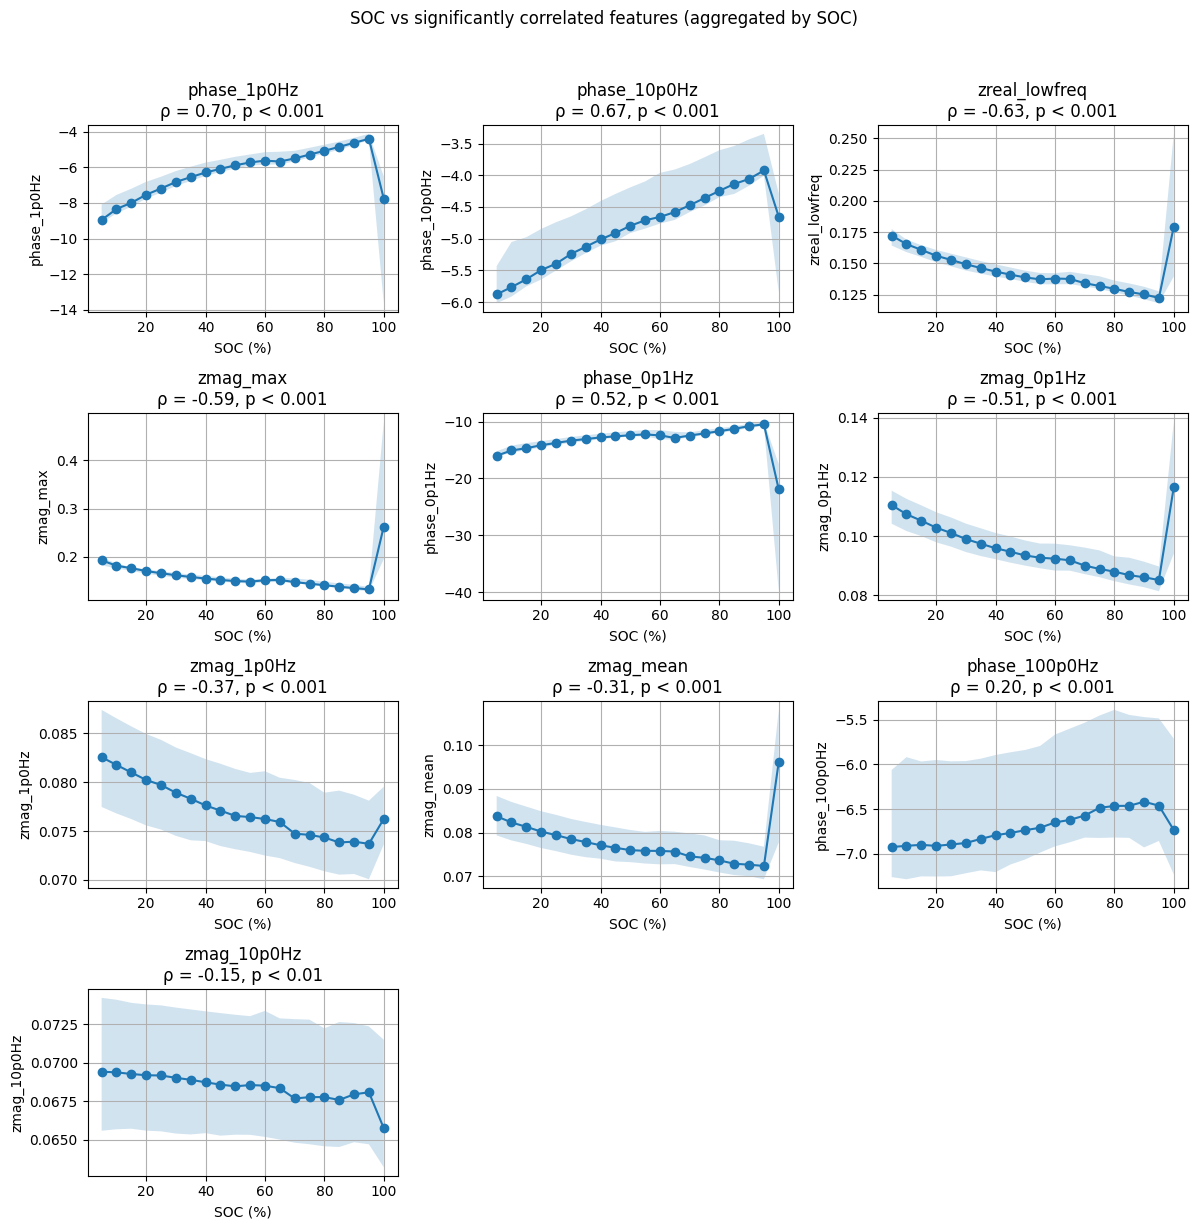

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse `corr` and `pvals` from the Spearman step (section 3.4)
p_soc = pvals.loc["soc"]
corr_soc = corr.loc["soc"]

# Significant features: p < 0.05, excluding SOC itself
mask = (p_soc < 0.05) & (p_soc.index != "soc")
sig_feats = p_soc.index[mask].tolist()

# Sort by |rho| so the strongest ones come first
sig_feats_sorted = sorted(sig_feats, key=lambda f: abs(corr_soc[f]), reverse=True)
print("Significant features (p < 0.05):", sig_feats_sorted)

# Precompute SOC order
soc_levels = sorted(feat_df["soc"].unique())

n = len(sig_feats_sorted)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for ax, feat in zip(axes, sig_feats_sorted):
    # group by SOC for this feature
    grouped = feat_df.groupby("soc")[feat]

    med = grouped.median().reindex(soc_levels)
    q25 = grouped.quantile(0.25).reindex(soc_levels)
    q75 = grouped.quantile(0.75).reindex(soc_levels)

    ax.plot(soc_levels, med, marker="o")
    ax.fill_between(soc_levels, q25, q75, alpha=0.2)

    rho = corr_soc[feat]
    p = p_soc[feat]
    if p < 0.001:
        p_str = "p < 0.001"
    elif p < 0.01:
        p_str = "p < 0.01"
    else:
        p_str = "p < 0.05"

    ax.set_xlabel("SOC (%)")
    ax.set_ylabel(feat)
    ax.set_title(f"{feat}\nρ = {rho:.2f}, {p_str}")
    ax.grid(True)

# Hide unused axes
for ax in axes[len(sig_feats_sorted):]:
    ax.set_visible(False)

fig.suptitle("SOC vs significantly correlated features (aggregated by SOC)", y=1.02)
plt.tight_layout()
plt.show()
